Preparing Unified Metadata for the RCC Dataset
This notebook performs the following steps:

1. Loads mapping JSON files for ccRCC, pRCC, CHROMO, and ONCO.
2. Loads dataset statistics.
3. Verifies that the number of mapped files matches the statistics.
4. Constructs a unified table with one row per WSI, including annotations and ROIs.
5. Exports the result to a CSV file for the downstream training pipeline.

---

In [147]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [148]:
!pip install pyyaml pandas

In [149]:
from pathlib import Path
import yaml

yaml_path = Path('/content/drive/MyDrive/ColabNotebooks/wsi-ssrl-rcc_project/config/preprocessing.yaml')
if not yaml_path.exists():
    yaml_path = Path('config/preprocessing.yaml')

# Cell 2 – Load and resolve preprocessing.yaml, substitute placeholders
import yaml
from pathlib import Path
import copy

class ConfigLoader:
    """
    Load preprocessing.yaml, select environment, and substitute placeholders.
    """
    def __init__(self, yaml_path: Path):
        self.yaml_path = yaml_path
        self.raw_cfg = self._load_yaml()
        self.resolved_base = self._select_environment()
        self.cfg = self._substitute_placeholders()

    def _load_yaml(self) -> dict:
        return yaml.safe_load(self.yaml_path.read_text())

    def _select_environment(self) -> Path:
        """Choose between colab and local base paths."""
        env = self.raw_cfg['environment']
        colab_root = Path(env['colab'])
        local_root = Path(env['local'])
        if colab_root.exists():
            return colab_root
        if local_root.exists():
            return local_root
        raise FileNotFoundError("Neither colab nor local environment path found.")

    def _substitute_placeholders(self) -> dict:
        """
        Resolve 'base' section, then substitute:
          - ${RESOLVED_BASE_DIR} → resolved_base
          - ${base.<key>}          → base[key]
        across data_paths, stage_overrides, patching_defaults.
        """
        cfg = copy.deepcopy(self.raw_cfg)

        # 1. Resolve base section
        base_section = cfg['base']
        resolved_base = str(self.resolved_base)
        resolved_base_section = {}
        for k, v in base_section.items():
            if isinstance(v, str):
                resolved = v.replace('${RESOLVED_BASE_DIR}', resolved_base)
            else:
                resolved = v
            resolved_base_section[k] = resolved
        cfg['base'] = resolved_base_section

        # 2. Prepare placeholder map
        placeholders = {'${RESOLVED_BASE_DIR}': resolved_base}
        for k, v in resolved_base_section.items():
            placeholders[f'${{base.{k}}}'] = str(v)

        # 3. Recursive replacement helper
        def replace(obj):
            if isinstance(obj, str):
                for ph, val in placeholders.items():
                    obj = obj.replace(ph, val)
                return obj
            if isinstance(obj, dict):
                return {k: replace(v) for k, v in obj.items()}
            if isinstance(obj, list):
                return [replace(v) for v in obj]
            return obj

        # 4. Apply to relevant sections
        for section in ['data_paths', 'stage_overrides', 'patching_defaults']:
            if section in cfg:
                cfg[section] = replace(cfg[section])

        return cfg

class PathResolver:
    """
    Resolve all filesystem paths from config, mapping data_paths under data_root
    into raw WSI paths under dataraw_root.
    """
    def __init__(self, cfg: dict):
        b  = cfg['base']
        dp = cfg['data_paths']

        # roots
        self.project_root  = Path(b['project_root'])
        self.data_root     = Path(b['data_root'])
        self.dataraw_root  = Path(b['dataraw_root'])
        self.mapping_root  = Path(b['mapping_root'])
        self.metadata_root = Path(b['metadata_root'])

        # helper: take any path under data_root and map to dataraw_root
        def to_raw(path_str: str) -> Path:
            p   = Path(path_str)
            rel = p.relative_to(self.data_root)
            return self.dataraw_root / rel

        # neoplastic WSI & XML
        self.ccrcc_wsi     = to_raw(dp['ccRCC']['wsi'])
        self.ccrcc_xml     = to_raw(dp['ccRCC']['xml'])
        self.pre_ccrcc_wsi = to_raw(dp['ccRCC']['pre']['wsi'])
        self.pre_ccrcc_xml = to_raw(dp['ccRCC']['pre']['xml'])

        self.prcc_wsi      = to_raw(dp['pRCC']['wsi'])
        self.prcc_xml      = to_raw(dp['pRCC']['xml'])
        self.pre_prcc_wsi  = to_raw(dp['pRCC']['pre']['wsi'])
        self.pre_prcc_xml  = to_raw(dp['pRCC']['pre']['xml'])

        # CHROMO & ONCO ROI dirs
        self.chromo_wsi         = to_raw(dp['CHROMO']['wsi'])
        self.chromo_annotations = to_raw(dp['CHROMO']['annotations'])
        self.onco_wsi           = to_raw(dp['ONCO']['wsi'])
        self.onco_annotations   = to_raw(dp['ONCO']['annotations'])

config_loader = ConfigLoader(yaml_path)
cfg = config_loader.cfg

In [150]:
# Cella 3 – JSON loader and consistency validator
import json
from pathlib import Path

class JSONLoader:
    """
    Load JSON file and return a Python dict.
    """
    @staticmethod
    def load(file_path: Path) -> dict:
        return json.loads(file_path.read_text())

class Validator:
    """
    Validate that actual counts match expected statistics.
    """
    @staticmethod
    def ensure_equal(name: str, actual: int, expected: int):
        if actual != expected:
            raise ValueError(f"[{name}] count mismatch: actual={actual}, expected={expected}")


In [151]:
# Cella 4 – Utilities for path relativity, patient ID extraction, and row building
from pathlib import Path

def relative_posix(path: Path, base: Path) -> str:
    """
    Return POSIX-style relative path from base to path.
    """
    return str(path.relative_to(base).as_posix())

def extract_patient_id(wsi_filename: str) -> str:
    """
    Extract patient ID from WSI filename by:
      1) dropping any suffix after the first underscore;
      2) splitting on dot and taking the first two segments.
    Examples:
      'HP02.10180.1A2.ccRCC.scn'      -> 'HP02.10180'
      'HP10.2986_A4_ccRCC.scn'        -> 'HP10.2986'
      'HP12.6073_A5_ccRCC.scn'        -> 'HP12.6073'
      'HP14.5971.something_else.svs'  -> 'HP14.5971'
    """
    # 1) part before underscore
    base = wsi_filename.split('_', 1)[0]
    # 2) split by dot and join first two
    parts = base.split('.')
    return '.'.join(parts[:2]) if len(parts) >= 2 else parts[0]


class RowBuilder:
    """
    Build metadata rows for neoplastic and ROI-based subtypes,
    computing source_dir relative to RAW WSI root.
    """
    def __init__(self, raw_root: Path):
        self.raw_root = raw_root

    def build_neoplastic(self, mapping: dict, subtype: str,
                         wsi_dir: Path, xml_dir: Path,
                         pre_wsi_dir: Path, pre_xml_dir: Path) -> list:
        rows = []
        for wsi_file, xml_list in mapping.items():
            std_path = wsi_dir / wsi_file
            pre_path = pre_wsi_dir / wsi_file
            if std_path.exists():
                src = relative_posix(wsi_dir, self.raw_root)
            elif pre_path.exists():
                src = relative_posix(pre_wsi_dir, self.raw_root)
            else:
                src = ""
            rows.append({
                "subtype":         subtype,
                "patient_id":      extract_patient_id(wsi_file),
                "wsi_filename":    wsi_file,
                "annotation_xml":  ";".join(xml_list),
                "num_annotations": len(xml_list),
                "roi_files":       "",
                "num_rois":        0,
                "source_dir":      src
            })
        return rows

    def build_roi(self, patient_map: dict, subtype: str,
                  wsi_dir: Path, annotation_dir: Path) -> list:
        rows = []
        for patient, info in patient_map.items():
            roi_files = info.get("roi_files", [])
            for wsi_file in info.get("wsi_files", []):
                rows.append({
                    "subtype":         subtype,
                    "patient_id":      patient,
                    "wsi_filename":    wsi_file,
                    "annotation_xml":  "",
                    "num_annotations": 0,
                    "roi_files":       ";".join(roi_files),
                    "num_rois":        len(roi_files),
                    "source_dir":      relative_posix(wsi_dir, self.raw_root)
                })
        return rows


In [152]:
# Cella 5 – Main orchestrator to load, validate, build and export metadata.csv
import pandas as pd
from pathlib import Path

class MetadataBuilder:
    """
    Orchestrates loading of mappings, validation, row building, and CSV export.
    """
    def __init__(self, cfg: dict):
        self.cfg       = cfg
        self.paths     = PathResolver(cfg)
        self.loader    = JSONLoader()
        self.validator = Validator()
        # <-- use dataraw_root here
        self.builder   = RowBuilder(self.paths.dataraw_root)

        self.map_root  = self.paths.mapping_root
        self.out_csv   = self.paths.metadata_root / "metadata.csv"

    def build_metadata(self):
        # 1. Load JSON mappings & stats
        cc_map     = self.loader.load(self.map_root / "ccRCC_mapping.json")
        pr_map     = self.loader.load(self.map_root / "pRCC_mapping.json")
        chromo_map = self.loader.load(self.map_root / "CHROMO_patient_mapping.json")
        onco_map   = self.loader.load(self.map_root / "ONCO_patient_mapping.json")
        stats      = self.loader.load(self.map_root / "rcc_dataset_stats.json")

        # 2. Validate counts
        self.validator.ensure_equal("ccRCC", len(cc_map), stats["ccRCC"]["n_wsis"])
        self.validator.ensure_equal("pRCC",  len(pr_map), stats["pRCC"]["n_wsis"])
        actual_ch = sum(len(v["wsi_files"]) for v in chromo_map.values())
        self.validator.ensure_equal("CHROMO", actual_ch, stats["CHROMO"]["n_wsis"])
        actual_on = sum(len(v["wsi_files"]) for v in onco_map.values())
        self.validator.ensure_equal("ONCO",   actual_on, stats["ONCO"]["n_wsis"])

        # 3. Build rows
        rows = []
        rows += self.builder.build_neoplastic(
            cc_map, "ccRCC",
            self.paths.ccrcc_wsi,    self.paths.ccrcc_xml,
            self.paths.pre_ccrcc_wsi, self.paths.pre_ccrcc_xml
        )
        rows += self.builder.build_neoplastic(
            pr_map, "pRCC",
            self.paths.prcc_wsi,     self.paths.prcc_xml,
            self.paths.pre_prcc_wsi,  self.paths.pre_prcc_xml
        )
        rows += self.builder.build_roi(
            chromo_map, "CHROMO",
            self.paths.chromo_wsi,   self.paths.chromo_annotations
        )
        rows += self.builder.build_roi(
            onco_map,   "ONCO",
            self.paths.onco_wsi,     self.paths.onco_annotations
        )

        # 4. Create DataFrame
        df = pd.DataFrame(rows)

        # 5. Filter out rows with no annotations AND no ROIs
        df = df[~((df['num_annotations'] == 0) & (df['num_rois'] == 0))]

        # 6. Export to CSV
        self.out_csv.parent.mkdir(parents=True, exist_ok=True)
        df.to_csv(self.out_csv, index=False)
        print(f"✅ Consolidated metadata saved to {self.out_csv} ({len(df)} entries)")
        return df


In [153]:
# Cella 6 – Load config and run metadata build

config = ConfigLoader(yaml_path).cfg
builder = MetadataBuilder(config)
df = builder.build_metadata()

✅ Consolidated metadata saved to /content/drive/MyDrive/ColabNotebooks/wsi-ssrl-rcc_project/data/mapping/metadata.csv (196 entries)


In [171]:
# Cell 7 – Strict patient_id validation for ccRCC/pRCC
import re
from IPython.display import display

# CHROMO and ONCO are exempt
exempt_subtypes = {"CHROMO", "ONCO"}

# Strict pattern: HP<digits>.<digits>, e.g. HP14.5971
patient_pattern = re.compile(r'^HP?\d+\.\d+$')

# Select only ccRCC and pRCC rows
mask_ccpcc = df['subtype'].isin(['ccRCC', 'pRCC'])

# Find rows where patient_id does NOT match the strict pattern
invalid_id_df = df[mask_ccpcc & ~df['patient_id'].str.match(patient_pattern)]

# Report
print(f"source_dir:{df.source_dir.unique()}\n")
print(f"subtype:{df.subtype.unique()}\n")
print(f"Distinct patients:{len(df.patient_id.unique())}\n")
print(f"All patient_id:{len(df.patient_id)}\n")
print(f"All distinct patients:{df.patient_id.unique()}\n")

print(f"🔴 Invalid patient_id for ccRCC/pRCC: {len(invalid_id_df)} rows")
# display(invalid_id_df)

# 2. Rows with neither annotations nor ROIs
no_annotation_roi_df = df[(df['num_annotations'] == 0) & (df['num_rois'] == 0)]
print(f"\n🔴 Rows with no annotations AND no ROIs: {len(no_annotation_roi_df)} rows")
# display(no_annotation_roi_df)

source_dir:['ccRCC' 'pre/ccRCC' 'pRCC' 'pre/pRCC' 'CHROMO' 'ONCOCYTOMA']

subtype:['ccRCC' 'pRCC' 'CHROMO' 'ONCO']

Distinct patients:88

All patient_id:196

All distinct patients:['HP19.754' 'HP19.10064' 'HP19.4372' 'HP19.8394' 'HP19.5524' 'HP19.7949'
 'HP19.7840' 'HP19.9347' 'HP19.4075' 'HP19.3695' 'HP19.9421' 'HP19.999'
 'HP19.7715' 'HP19.2434' 'HP19.7421' 'H19.754' 'HP19.5254' 'HP19.7864'
 'HP15.12550' 'HP12.8355' 'HP12.9282' 'HP14.1749' 'HP13.7465' 'HP12.6691'
 'HP14.7813' 'HP14.11034' 'HP11.12318' 'HP10.2695' 'HP12.7225' 'HP16.819'
 'HP12.390' 'HP10.2986' 'HP13.1799' 'HP12.6073' 'HP02.10180' 'HP15.11259'
 'HP12.3187' 'HP14.5347' 'HP15.2902' 'HP16.6209' 'HP14.1993' 'HP12.4271'
 'HP15.1480' 'HP14.9097' 'HP12.8793' 'HP12.13358' 'HP10.5813' 'HP13.6992'
 'HP11.12277' 'HP12.13588' 'HP14.9685' 'HP14.69' 'HP16.6211' 'HP12.5998'
 'HP14.13101' 'HP14.5590' 'HP17.11714' 'HP18.5818' 'HP19.1773' 'HP17.7980'
 'HP18.11474' 'HP19.1277' 'HP18.13618' 'HP12.6710' 'HP14.10122'
 'HP12.7726' 'HP14.5971

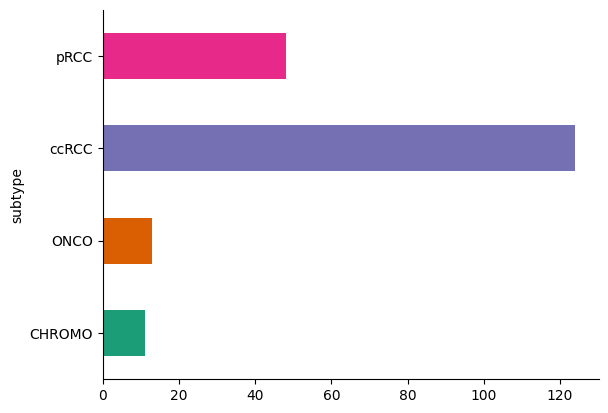

In [155]:
# @title subtype

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('subtype').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)